#Suspicious Activity Detection using Detectron2 Step by Step Tutorial

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

Welcome to detectron2! This is a copy of official colab tutorial of detectron2. Here, we will go through some basics usage of detectron2, including the following:
* Train a detectron2 model on a new custom dataset
* Upload the Custom Dataset to your drive and extract it to your runtime


#Mounting Google Drive 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#Custom Dataset Extraction from Drive 

In [ ]:
!unrar x "/content/drive/MyDrive/TFOD7.rar" "/content"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/drive/MyDrive/TFOD7.rar

Creating    /content/TFOD7                                            OK
Creating    /content/TFOD7/test                                       OK
Extracting  /content/TFOD7/test/Fighting003_x264_mp4-100_jpg.rf.30461835405091f0e8e26a3ecda09c24.jpg       0%  OK 
Extracting  /content/TFOD7/test/Fighting003_x264_mp4-74_jpg.rf.4f0456d04cf174371723655faa378b49.jpg       0%  OK 
Extracting  /content/TFOD7/test/Fighting006_x264_mp4-27_jpg.rf.ed99a067f2ab189c57859972a56d63eb.jpg       0%  OK 
Extracting  /content/TFOD7/test/Fighting006_x264_mp4-42_jpg.rf.b85e2d0c20c0f8b80f7262aee9ecbbcd.jpg       0%  OK 
Extracting  /content/TFOD7/test/Fighting006_x264_mp4-46_jpg.rf.8c8a2b1cf10fd88829440e3e1fa670c4.jpg       0%  OK 
Extracting  /content/TFOD7/test/Fighting013_x264_mp4-14_jpg.rf.560d98841d3ae0e82fdf3f1b48b8cb0b.jpg       0%  

# Install detectron2

In [ ]:
!python -m pip install pyyaml==5.1
# Detectron2 has not released pre-built binaries for the latest pytorch (https://github.com/facebookresearch/detectron2/issues/4053)
# so we install from source instead. This takes a few minutes.
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

# Install pre-built detectron2 that matches pytorch version, if released:
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/{CUDA_VERSION}/{TORCH_VERSION}/index.html

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 274 kB 33.5 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=ebc83a34ffdb414f10394babb1f968550eb759f5fa0385f284dca899792b5c3a
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2022.2.0 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
torch:  1.12 ; cuda:  cu113
detectron2: 0.6


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog



## Prepare the dataset

Register the custom dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).
Here, the dataset is in its custom format, therefore we write a function to parse it and prepare it into detectron2's standard format. User should write such a function when using a dataset in custom format. See the tutorial for more details.


In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/TFOD7/train/_annotations.json", "/content/TFOD7/train")
register_coco_instances("my_dataset_val", {}, "/content/TFOD7/valid/_annotations.json", "/content/TFOD7/valid")
register_coco_instances("my_dataset_test", {}, "/content/TFOD7/test/_annotations.json", "/content/TFOD7/test")

#Visualizing the Data 
    
    * Check the dataset is in proper COCO Format 

WARNING [10/12 05:18:11 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[10/12 05:18:11 d2.data.datasets.coco]: Loaded 2137 images in COCO format from /content/TFOD7/train/_annotations.json


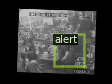

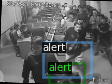

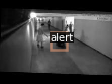

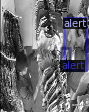

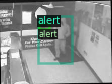

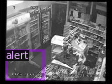

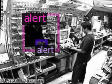

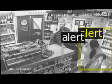

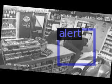

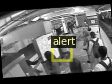

In [ ]:
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 10):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

##Configuration Paramater settings

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)

cfg.DATALOADER.NUM_WORKERS = 4 
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
#cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth") # loading the trained weights

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.001


cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 2000 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (3000, 4000)
cfg.SOLVER.GAMMA = 0.05

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 16
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

cfg.TEST.EVAL_PERIOD = 1000

In [ ]:
import os
import logging
from torch.utils.tensorboard import SummaryWriter
from detectron2.utils.events import EventWriter, get_event_storage
from detectron2.engine import HookBase
from detectron2.data import build_detection_train_loader
import detectron2.utils.comm as comm
from detectron2.engine import DefaultPredictor
from detectron2.evaluation import COCOEvaluator
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.utils.events import CommonMetricPrinter, JSONWriter, TensorboardXWriter
from detectron2.engine.hooks import PeriodicWriter

In [ ]:
class CustomTensorboardXWriter(EventWriter):
    """
    Writes scalars and images based on storage key to train or val tensorboard file.

    Reference: https://github.com/facebookresearch/detectron2/issues/810#issuecomment-933314459
    """

    def __init__(self, log_dir: str, window_size: int = 20, **kwargs):
        """
        Args:
            log_dir (str): the base directory to save the output events. This class creates two subdirs in log_dir
            window_size (int): the scalars will be median-smoothed by this window size

            kwargs: other arguments passed to `torch.utils.tensorboard.SummaryWriter(...)`
        """
        self._window_size = window_size

        self.logger = logging.getLogger(__name__)

        # separate the writers into a train and a val writer
        train_writer_path = os.path.join(log_dir, "train")
        os.makedirs(train_writer_path, exist_ok=True)
        self._writer_train = SummaryWriter(train_writer_path, **kwargs)

        val_writer_path = os.path.join(log_dir, "val")
        os.makedirs(val_writer_path, exist_ok=True)
        self._writer_val = SummaryWriter(val_writer_path, **kwargs)

    def write(self):

        storage = get_event_storage()
        for k, (v, iter) in storage.latest_with_smoothing_hint(self._window_size).items():
            if k.startswith("val_"):
                k = k.replace("val_", "")
                self._writer_val.add_scalar(k, v, iter)
            else:
                self._writer_train.add_scalar(k, v, iter)

        if len(storage._vis_data) >= 1:
            for img_name, img, step_num in storage._vis_data:
                self.logger.info(f"processing key {k} with info {img_name}, {img}, {step_num}")
                if k.startswith("val_"):
                    k = k.replace("val_", "")
                    self._writer_val.add_image(img_name, img, step_num)
                else:
                    self._writer_train.add_image(img_name, img, step_num)
            # Storage stores all image data and rely on this writer to clear them.
            # As a result it assumes only one writer will use its image data.
            # An alternative design is to let storage store limited recent
            # data (e.g. only the most recent image) that all writers can access.
            # In that case a writer may not see all image data if its period is long.
            storage.clear_images()

        if len(storage._histograms) >= 1:
            for params in storage._histograms:
                self._writer_train.add_histogram_raw(**params)
            storage.clear_histograms()

    def close(self):
        if hasattr(self, "_writer"):  # doesn't exist when the code fails at import
            self._writer_train.close()
            self._writer_val.close()






In [ ]:
class Trainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "eval_output")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)

    def build_writers(self):
        """
        Overwrites the default writers to contain our custom tensorboard writer

        Returns:
            list[EventWriter]: a list of :class:`EventWriter` objects.
        """
        return [
            CommonMetricPrinter(self.max_iter),
            JSONWriter(os.path.join(self.cfg.OUTPUT_DIR, "metrics.json")),
            CustomTensorboardXWriter(self.cfg.OUTPUT_DIR),
        ]

In [ ]:
from detectron2.engine import HookBase
from detectron2.data import build_detection_test_loader
from detectron2.data import DatasetMapper

import detectron2.utils.comm as comm
class ValLossHook(HookBase):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg.clone()
        self._loader = iter(build_detection_test_loader(self.cfg, cfg.DATASETS.TEST, mapper = DatasetMapper(self.cfg,is_train=True)))

    def after_step(self):
        """
        After each step calculates the validation loss and adds it to the train storage
        """
        
        try:
          data = next(self._loader)
          with torch.no_grad():
              loss_dict = self.trainer.model(data)

              losses = sum(loss_dict.values())
              assert torch.isfinite(losses).all(), loss_dict

              loss_dict_reduced = {"validation_" + k: v.item() for k, v in comm.reduce_dict(loss_dict).items()}
              losses_reduced = sum(loss for loss in loss_dict_reduced.values())
              if comm.is_main_process():
                  self.trainer.storage.put_scalars(validation_total_loss=losses_reduced, **loss_dict_reduced)
        except StopIteration:
           pass

In [ ]:
os.makedirs(cfg.OUTPUT_DIR,exist_ok=True)
trainer = Trainer(cfg)
#val_loss = ValLossHook(cfg)
trainer.register_hooks([ValLossHook(cfg)])

# The PeriodicWriter needs to be the last hook, otherwise it wont have access to valloss metrics 
# Ensure PeriodicWriter is the last called hook
periodic_writer_hook = [hook for hook in trainer._hooks if isinstance(hook, PeriodicWriter)]
all_other_hooks = [hook for hook in trainer._hooks if not isinstance(hook, PeriodicWriter)]
trainer._hooks = all_other_hooks + periodic_writer_hook
trainer.resume_or_load(resume = False)
trainer.train()


[10/12 05:27:33 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
model_final_68b088.pkl: 421MB [04:14, 1.66MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[10/12 05:31:48 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[10/12 05:32:40 d2.utils.events]:  eta: 1:05:30  iter: 19  total_loss: 1.661  loss_cls: 0.6605  loss_box_reg: 0.9638  loss_rpn_cls: 0.02848  loss_rpn_loc: 0.009962  validation_total_loss: 1.606  validation_loss_cls: 0.6394  validation_loss_box_reg: 0.9161  validation_loss_rpn_cls: 0.01672  validation_loss_rpn_loc: 0.008132  time: 1.9672  data_time: 0.0230  lr: 1.9981e-05  max_mem: 5694M
[10/12 05:33:24 d2.utils.events]:  eta: 1:04:40  iter: 39  total_loss: 1.524  loss_cls: 0.5975  loss_box_reg: 0.8997  loss_rpn_cls: 0.01883  loss_rpn_loc: 0.01083  validation_total_loss: 1.515  validation_loss_cls: 0.576  validation_loss_box_reg: 0.9308  validation_loss_rpn_cls: 0.01734  validation_loss_rpn_loc: 0.008282  time: 1.9521  data_time: 0.0065  lr: 3.9961e-05  max_mem: 5694M
[10/12 05:34:07 d2.utils.events]:  eta: 1:04:01  iter: 59  total_loss: 1.536  loss_cls: 0.4938  loss_box_reg: 0.9562  loss_rpn_cls: 0.05175  loss_rpn_loc: 0.009015  validation_total_loss: 1.62  validation_loss_cls: 0.5054 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[10/12 06:05:00 d2.evaluation.evaluator]: Inference done 11/214. Dataloading: 0.0011 s/iter. Inference: 0.2689 s/iter. Eval: 0.0002 s/iter. Total: 0.2702 s/iter. ETA=0:00:54
[10/12 06:05:05 d2.evaluation.evaluator]: Inference done 30/214. Dataloading: 0.0017 s/iter. Inference: 0.2686 s/iter. Eval: 0.0002 s/iter. Total: 0.2707 s/iter. ETA=0:00:49
[10/12 06:05:10 d2.evaluation.evaluator]: Inference done 49/214. Dataloading: 0.0017 s/iter. Inference: 0.2681 s/iter. Eval: 0.0002 s/iter. Total: 0.2702 s/iter. ETA=0:00:44
[10/12 06:05:16 d2.evaluation.evaluator]: Inference done 68/214. Dataloading: 0.0018 s/iter. Inference: 0.2682 s/iter. Eval: 0.0002 s/iter. Total: 0.2704 s/iter. ETA=0:00:39
[10/12 06:05:21 d2.evaluation.evaluator]: Inference done 87/214. Dataloading: 0.0019 s/iter. Inference: 0.2679 s/iter. Eval: 0.0002 s/iter. Total: 0.2702 s/iter. ETA=0:00:34
[10/12 06:05:26 d2.evaluation.evaluator]: Inference done 106/214. Dataloading: 0.0020 s/iter. Inference: 0.2680 s/iter. Eval: 0.00

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[10/12 06:38:21 d2.evaluation.evaluator]: Inference done 11/214. Dataloading: 0.0011 s/iter. Inference: 0.2678 s/iter. Eval: 0.0002 s/iter. Total: 0.2692 s/iter. ETA=0:00:54
[10/12 06:38:26 d2.evaluation.evaluator]: Inference done 30/214. Dataloading: 0.0015 s/iter. Inference: 0.2687 s/iter. Eval: 0.0002 s/iter. Total: 0.2706 s/iter. ETA=0:00:49
[10/12 06:38:31 d2.evaluation.evaluator]: Inference done 49/214. Dataloading: 0.0018 s/iter. Inference: 0.2687 s/iter. Eval: 0.0002 s/iter. Total: 0.2708 s/iter. ETA=0:00:44
[10/12 06:38:36 d2.evaluation.evaluator]: Inference done 68/214. Dataloading: 0.0019 s/iter. Inference: 0.2690 s/iter. Eval: 0.0002 s/iter. Total: 0.2713 s/iter. ETA=0:00:39
[10/12 06:38:42 d2.evaluation.evaluator]: Inference done 87/214. Dataloading: 0.0019 s/iter. Inference: 0.2694 s/iter. Eval: 0.0002 s/iter. Total: 0.2716 s/iter. ETA=0:00:34
[10/12 06:38:47 d2.evaluation.evaluator]: Inference done 106/214. Dataloading: 0.0018 s/iter. Inference: 0.2697 s/iter. Eval: 0.00

# Evaluating the trained model by plotting training and validation loss

In [ ]:
import json
import matplotlib.pyplot as plt

experiment_folder = '/content/output/'
def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

experiment_metrics = load_json_arr(experiment_folder + '/metrics.json')
iters_total_loss = [x['iteration'] for x in experiment_metrics if 'total_loss' in x]
total_loss = [x['total_loss'] for x in experiment_metrics if 'total_loss' in x]
iters_val_loss = [x['iteration'] for x in experiment_metrics if 'validation_total_loss' in x]
val_loss = [x['validation_total_loss'] for x in experiment_metrics if 'validation_total_loss' in x]
#iters_ap50 = [x['iteration'] for x in experiment_metrics if 'bbox/AP50' in x]
#ap50 = [x['bbox/AP50'] for x in experiment_metrics if 'bbox/AP50' in x]

#fig, ax = plt.subplots(2,1)
plt.plot(iters_total_loss, total_loss)
plt.plot(iters_val_loss, val_loss)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend(['training_loss', 'validation_loss'])



#fig, ax = plt.subplots(2,1)
#ax[0].plot(iters_total_loss, total_loss)
#ax[0].plot(iters_val_loss, val_loss)
#ax[0].set_xlabel('iteration')
#ax[0].set_ylabel('loss')
#ax[0].legend(['total_loss', 'validation_total_loss'], loc='best')
#iter = val_loss.index(min(val_loss))
#ax[0].vlines(iters_val_loss[iter], 0, float(max(val_loss)),color="red")
#ax[0].annotate('min val loss: %f at iter: %d'%(float(min(val_loss)),int(iters_val_loss[iter])),xy=(iters_val_loss[iter],min(val_loss)),xytext=(+15,+15),textcoords='offset points',fontsize=8) #arrowprops=dict(arrowstyle='->',connectionstyle='arc3,rad=.2')
#ax[0].set_xlim([0,max(max(iters_total_loss),max(iters_val_loss))])
#ax[0].set_ylim([0,max(1.1*max(total_loss),1.1*max(val_loss))])

#ax[1].plot(iters_ap50, ap50)
#ax[1].set_xlabel('iteration')
#ax[1].set_ylabel('AP50(%)')
#iter = ap50.index(max(ap50))
#ax[1].vlines(iters_ap50[iter], 0, 5+float(max(ap50)),color="red")
#ax[1].annotate('max ap50: %f at iter: %d'%(float(max(ap50)),int(iters_ap50[iter])),xy=(iters_ap50[iter],max(ap50)),xytext=(+15,-25),textcoords='offset points',fontsize=8) #arrowprops=dict(arrowstyle='->',connectionstyle='arc3,rad=.2')
#ax[1].set_xlim([0,max(iters_ap50)])
#ax[1].set_ylim([0,100])

plt.tight_layout()
plt.show()
#path = experiment_folder + '/loss&AP50.jpg'
#plt.savefig(path)
plt.close()

In [ ]:
print('test model final:')
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 # set a custom testing threshold
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("my_dataset_test", ("bbox",), False, output_dir="./output_final/")
val_loader = build_detection_test_loader(cfg, "my_dataset_test")
print(inference_on_dataset(trainer.model, val_loader, evaluator))

test model final:
[10/12 08:28:18 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (256,) (256,) (256,) (256,) (256,8,3,3)         |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[10/12 08:28:22 d2.evaluation.evaluator]: Inference done 11/111. Dataloading: 0.0014 s/iter. Inference: 0.2600 s/iter. Eval: 0.0002 s/iter. Total: 0.2616 s/iter. ETA=0:00:26
[10/12 08:28:27 d2.evaluation.evaluator]: Inference done 30/111. Dataloading: 0.0020 s/iter. Inference: 0.2608 s/iter. Eval: 0.0002 s/iter. Total: 0.2632 s/iter. ETA=0:00:21
[10/12 08:28:32 d2.evaluation.evaluator]: Inference done 49/111. Dataloading: 0.0020 s/iter. Inference: 0.2612 s/iter. Eval: 0.0002 s/iter. Total: 0.2636 s/iter. ETA=0:00:16
[10/12 08:28:37 d2.evaluation.evaluator]: Inference done 68/111. Dataloading: 0.0020 s/iter. Inference: 0.2620 s/iter. Eval: 0.0002 s/iter. Total: 0.2644 s/iter. ETA=0:00:11
[10/12 08:28:42 d2.evaluation.evaluator]: Inference done 87/111. Dataloading: 0.0020 s/iter. Inference: 0.2635 s/iter. Eval: 0.0002 s/iter. Total: 0.2659 s/iter. ETA=0:00:06
[10/12 08:28:47 d2.evaluation.evaluator]: Inference done 107/111. Dataloading: 0.0021 s/iter. Inference: 0.2621 s/iter. Eval: 0.00

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

## Inference & evaluation 



WARNING [10/05 10:34:12 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[10/05 10:34:12 d2.data.datasets.coco]: Loaded 111 images in COCO format from /content/TFOD7/test/_annotations.json


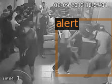

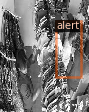

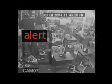

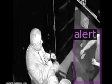

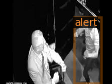

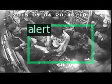

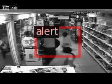

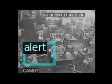

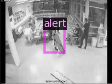

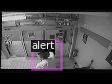

In [ ]:
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_test")
dataset_dicts = DatasetCatalog.get("my_dataset_test")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 10):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

Then, we randomly select several samples to visualize the prediction results.

In [ ]:
from detectron2.utils.visualizer import ColorMode
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_test")
dataset_dicts = DatasetCatalog.get("my_dataset_test")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=my_dataset_train_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

We can also evaluate its performance using AP metric implemented in COCO API.
This gives an AP of ~70. Not bad!

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("my_dataset_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

WARNING [10/05 10:38:56 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[10/05 10:38:56 d2.data.datasets.coco]: Loaded 214 images in COCO format from /content/TFOD7/valid/_annotations.json
[10/05 10:38:56 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[10/05 10:38:56 d2.data.common]: Serializing 214 elements to byte tensors and concatenating them all ...
[10/05 10:38:56 d2.data.common]: Serialized dataset takes 0.06 MiB
[10/05 10:38:56 d2.evaluation.evaluator]: Start inference on 214 batches


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[10/05 10:38:59 d2.evaluation.evaluator]: Inference done 11/214. Dataloading: 0.0011 s/iter. Inference: 0.2665 s/iter. Eval: 0.0003 s/iter. Total: 0.2678 s/iter. ETA=0:00:54
[10/05 10:39:04 d2.evaluation.evaluator]: Inference done 30/214. Dataloading: 0.0025 s/iter. Inference: 0.2688 s/iter. Eval: 0.0002 s/iter. Total: 0.2717 s/iter. ETA=0:00:50
[10/05 10:39:09 d2.evaluation.evaluator]: Inference done 49/214. Dataloading: 0.0023 s/iter. Inference: 0.2705 s/iter. Eval: 0.0002 s/iter. Total: 0.2732 s/iter. ETA=0:00:45
[10/05 10:39:15 d2.evaluation.evaluator]: Inference done 67/214. Dataloading: 0.0024 s/iter. Inference: 0.2724 s/iter. Eval: 0.0002 s/iter. Total: 0.2751 s/iter. ETA=0:00:40
[10/05 10:39:20 d2.evaluation.evaluator]: Inference done 85/214. Dataloading: 0.0023 s/iter. Inference: 0.2741 s/iter. Eval: 0.0002 s/iter. Total: 0.2767 s/iter. ETA=0:00:35
[10/05 10:39:25 d2.evaluation.evaluator]: Inference done 103/214. Dataloading: 0.0022 s/iter. Inference: 0.2755 s/iter. Eval: 0.00